In [68]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [3]:
# df_train

In [4]:
# train_transaction.head()

In [5]:
# train_identity.head()

In [6]:
# train_transaction.info();

In [7]:
# train_identity.info();

In [8]:
# df_train.shape

In [9]:
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

### Assigning columns to specific lists (cat, num, date, etc.)

In [10]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = ['isFraud']

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i + col_target)))

# col_all = col_cat + col_num + col_date + col_bool + col_id + col_target
# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [62]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
                
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 100:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info

# determine what to do with columns that have too many unique values... obviously.. types of solutions
# would be to put "MISSING" for those that dont have an email address... but you will need to evaluate 
# and make instead a counter of unique values, then append that and look at the CSV via google sheets. use 
# something like the code below 

# Planning - our preprocessing method must automatically drop missing values, but we can't do that because
# we need to see about filling them in first, then decide if we need to drop them. Right now, we need to
# create a dataframe that shows unique values for each column with missing values. 

# we need to look at each variable and see if it's unique or categorical. We need to use possibly PCA...? How do
# we handle so many variables? 

There were 0 columns with null values.


In [65]:
pp.df_train = pp.impute_features()

label encoded: addr1 unique 333
dummies encoded: addr2 unique 75
dummies encoded: ProductCD unique 5
dummies encoded: P_emaildomain unique 59
label encoded: card1 unique 13553
label encoded: card2 unique 501
label encoded: card3 unique 115
dummies encoded: card4 unique 4
label encoded: card5 unique 120
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 358)


In [15]:
# # c is num, ex, how many addresses associated with card
# col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# # d is num, time/days between transactions
# col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# # m is date of transaction
# col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# # v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
# col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# # i is identity information like network and digital signature associated with transaction
# col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# # ca is cat, card information such as card type, etc. 
# col_card = [ca for ca in df_train.columns if ca.startswith('card')]

In [16]:
# # c is num, ex, how many addresses associated with card
# col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# # d is num, time/days between transactions
# col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# # m is date of transaction
# col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# # v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
# col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# # i is identity information like network and digital signature associated with transaction
# col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# # ca is cat, card information such as card type, etc. 
# col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# # D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# # associated with card, M=True/False, V created features on ranking, counting, etc. 

# # column id and target
# col_id = ['TransactionID']
# col_target = ['isFraud']

# # converting categorical columns with numerical values to string types.
# col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
# for val in col_cat_to_obj:
#     df_train[val] = df_train[val].astype(str)

# # categorical columns
# col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# # C counter, D is time elapsed between transactions, V feature engineered variables by firm
# col_num = ['TransactionAmt'] + col_c + col_d + col_v

# # figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
# col_date = ['TransactionDT'] 

# # boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# # col_bool = col_m

# # confirming all columns are accounted for
# print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i + col_target)))

# # col_all = col_cat + col_num + col_date + col_bool + col_id + col_target
# # columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

In [17]:
# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [19]:
# create features, target and split the dataframe
X = pp.df_train.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
y = pp.df_train[col_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

## Applying PCA (2 components)

In [20]:
# standardizing our data, which is required for PCA.
scaled_X = StandardScaler().fit_transform(X)
pd.DataFrame(scaled_X, columns=X.columns).head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,C1,C2,C3,...,card4_visa,card6_credit,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T
0,-1.577987,-0.278167,-0.888787,1.474598,-0.283337,-1.352159,0.005408,-0.098020,-0.092260,-0.037493,...,-1.375509,1.721548,-1.721201,-0.007128,0.006507,0.247059,0.359867,-0.313436,2.977336,1.433410
1,-1.577986,-0.443327,0.244063,0.237476,-0.283337,-2.377698,0.080118,-0.098020,-0.092260,-0.037493,...,-1.375509,1.721548,-1.721201,-0.007128,0.006507,0.247059,0.359867,-0.313436,-0.335871,1.433410
2,-1.577972,-0.317889,0.611453,0.777539,-0.283337,-0.782415,0.133482,-0.098020,-0.092260,-0.037493,...,0.727004,-0.580873,0.580990,-0.007128,0.006507,0.247059,0.359867,-0.313436,-0.335871,-0.697637
3,-1.577965,-0.355521,0.009949,1.261084,-0.283337,-2.035852,1.243452,-0.090533,-0.066398,-0.037493,...,-1.375509,-0.580873,0.580990,-0.007128,0.006507,0.247059,0.359867,-0.313436,-0.335871,-0.697637
4,-1.577964,-0.355521,0.581026,0.928255,-0.283337,-2.377698,0.805868,-0.098020,-0.092260,-0.037493,...,-1.375509,1.721548,-1.721201,-0.007128,0.006507,0.247059,0.359867,-0.313436,-0.335871,-0.697637


In [21]:
# PCA instantiate and fit 
pca = PCA(n_components=2)
pcomponents = pca.fit_transform(scaled_X)
X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
print(X_pca.shape)
X_pca.head()

array([[-1.81244549, -0.30100909],
       [-0.83413061, -0.48468871],
       [-2.09146977, -0.43427297],
       ...,
       [-3.50186197, -0.29587031],
       [-0.47574407,  0.73277775],
       [-3.49017237,  1.28271705]])

Variance ratio:
[0.10664484 0.08555304]

Principal components explained:


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,C1,C2,C3,...,card4_visa,card6_credit,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T
PC1,-0.003112,-0.021802,0.002625,0.010943,0.110125,-0.029544,0.093812,0.013862,0.016591,0.000465,...,-0.009203,0.030246,-0.030254,-0.000508,0.000476,0.017304,0.025243,-0.015967,0.131673,-0.046781
PC2,0.013962,0.007868,-0.004108,0.004480,-0.024582,-0.013721,-0.017571,-0.003483,-0.004015,0.002302,...,-0.009852,0.011927,-0.011921,-0.000037,0.000075,-0.001982,-0.002166,0.003167,-0.027961,0.002917


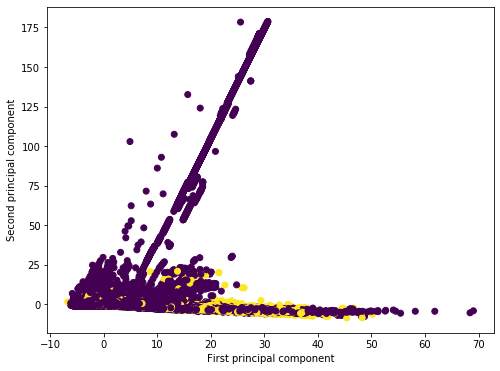

In [25]:
# two principal components scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

# explaining vaariance
print('Variance ratio:')
print(pca.explained_variance_ratio_)
# interpreting principal components
print('\nPrincipal components explained:')
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

## Applying PCA to all features (all components)

In [26]:
pca2 = PCA().fit(scaled_X)
# pca2.explained_variance_ratio_
# np.cumsum(pca2.explained_variance_ratio_)

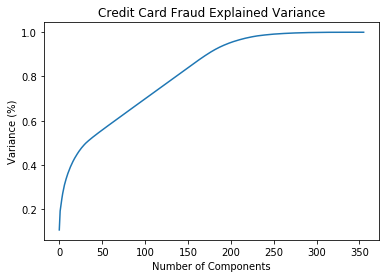

In [29]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Credit Card Fraud Explained Variance')
plt.show()

## Model w/ SMOTE only - base model

In [71]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

In [72]:
# Apply SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train1, y_train1)

In [74]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_res, y_train_res) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
# predicting on test set w/o PCA
print("Predicting using only SMOTE (and w/o PCA)\n")
y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr.score(X_test1, y_test1))
print(recall_score(y_test1, y_pred_test1))
print("\nConfusion Matrix")
print(confusion_matrix(y_test1, y_pred_test1))
print('\nClassification Report:\n')
print(classification_report(y_test1, y_pred_test1))

# predicting on original dataset
print("Whole dataset:")
y_pred = model_lr.predict(X)
print("\nTest Results")
print(model_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))

Predicting using only SMOTE (and w/o PCA)

Test set:
Validation results
0.5908321197548007
0.7211948790896159

Confusion Matrix
[[33370 23575]
 [  588  1521]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.59      0.73     56945
           1       0.06      0.72      0.11      2109

    accuracy                           0.59     59054
   macro avg       0.52      0.65      0.42     59054
weighted avg       0.95      0.59      0.71     59054

Whole dataset:

Test Results
0.590129373116131
0.7294681314426753

Confusion Matrix
[[333422 236455]
 [  5590  15073]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.59      0.73    569877
           1       0.06      0.73      0.11     20663

    accuracy                           0.59    590540
   macro avg       0.52      0.66      0.42    590540
weighted avg       0.95      0.59      0.71    590540



## IN PROGR - Model w/PCA  w/SMOTE

In [106]:
X.shape

(590540, 356)

In [107]:
# applying PCA
scaled_X = StandardScaler().fit_transform(X)
pca = PCA(n_components=250)
pcomponents = pca.fit_transform(scaled_X)
X_pca = pd.DataFrame(data=pcomponents)
print(X_pca.shape)

(590540, 250)


In [108]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)


In [109]:
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)
model_lr_pca = LogisticRegression(random_state=42)
model_lr_pca.fit(X_train_res, y_train_res)

In [110]:
# model_lr_pca = LogisticRegression(random_state=42)
# model_lr_pca.fit(X_train_res, y_train_res)
# y_pred_pca = model_lr_pca.predict(X_test2)

# NEXT, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
# predicting on test set w/o PCA
print("Predicting using PCA\n")
y_pred_pca = model_lr_pca.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr_pca.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca = model_lr_pca.predict(X_pca)
print("\nTest Results")
print(model_lr_pca.score(X_pca, y))
print(recall_score(y, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca))

Predicting using PCA

Test set:
Validation results
0.7700917804043756
0.7434803224276908

Confusion Matrix
[[43909 13036]
 [  541  1568]]

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     56945
           1       0.11      0.74      0.19      2109

    accuracy                           0.77     59054
   macro avg       0.55      0.76      0.53     59054
weighted avg       0.96      0.77      0.84     59054

Whole dataset:

Test Results
0.7715480746435466
0.7426317572472535

Confusion Matrix
[[440285 129592]
 [  5318  15345]]

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.77      0.87    569877
           1       0.11      0.74      0.19     20663

    accuracy                           0.77    590540
   macro avg       0.55      0.76      0.53    590540
weighted avg       0.96      0.77      0.84    590540



### Model - Decision Tree - w/PCA w/SMOTE

In [112]:
from sklearn.tree import DecisionTreeClassifier

In [113]:
model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)

TypeError: predict() missing 1 required positional argument: 'X'

In [114]:
# predicting on test set w/o PCA
print("Predicting using PCA\n")
y_pred_pca = model_dt_pca_smote.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_dt_pca_smote.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca = model_dt_pca_smote.predict(X_pca)
print("\nTest Results")
print(model_dt_pca_smote.score(X_pca, y))
print(recall_score(y, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca))

Predicting using PCA

Test set:
Validation results
0.9240694957157856
0.5514461830251304

Confusion Matrix
[[53407  3538]
 [  946  1163]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     56945
           1       0.25      0.55      0.34      2109

    accuracy                           0.92     59054
   macro avg       0.61      0.74      0.65     59054
weighted avg       0.96      0.92      0.94     59054

Whole dataset:

Test Results
0.9924069495715786
0.9542176837826066

Confusion Matrix
[[566339   3538]
 [   946  19717]]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    569877
           1       0.85      0.95      0.90     20663

    accuracy                           0.99    590540
   macro avg       0.92      0.97      0.95    590540
weighted avg       0.99      0.99      0.99    590540



In [ ]:
#####################

In [88]:
print("Variance ratio:")
print(pca.explained_variance_ratio_)
print("\nPrincipal components explained:")
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

Variance ratio:
[0.10664484 0.08555304]

Principal components explained:


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,C1,C2,C3,...,card4_visa,card6_credit,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T
PC1,-0.003112,-0.021802,0.002625,0.010943,0.110125,-0.029544,0.093812,0.013862,0.016591,0.000465,...,-0.009203,0.030246,-0.030254,-0.000508,0.000476,0.017304,0.025243,-0.015967,0.131673,-0.046781
PC2,0.013962,0.007868,-0.004108,0.004480,-0.024582,-0.013721,-0.017571,-0.003483,-0.004015,0.002302,...,-0.009852,0.011927,-0.011921,-0.000037,0.000075,-0.001982,-0.002166,0.003167,-0.027961,0.002917


In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [30]:
# applying SMOTE to train set to correct class imbalance
sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [31]:
# fitting to residuals created by SMOTE
clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
clf_lr.fit(X_train_res, y_train_res);

In [32]:
# predicting on test set
y_test_pred = clf_lr.predict(X_test)
print("Validation results")
print(clf_lr.score(X_test, y_test))
print(recall_score(y_test, y_test_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:\n')
print(classification_report(y_test, y_test_pred))

Validation results
0.5908321197548007
0.7211948790896159

Confusion Matrix
[[33370 23575]
 [  588  1521]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.59      0.73     56945
           1       0.06      0.72      0.11      2109

    accuracy                           0.59     59054
   macro avg       0.52      0.65      0.42     59054
weighted avg       0.95      0.59      0.71     59054



In [33]:
# predicting on original dataset
y_pred = clf_lr.predict(X)
print("\nTest Results")
print(clf_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))


Test Results
0.590129373116131
0.7294681314426753

Confusion Matrix
[[333422 236455]
 [  5590  15073]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.59      0.73    569877
           1       0.06      0.73      0.11     20663

    accuracy                           0.59    590540
   macro avg       0.52      0.66      0.42    590540
weighted avg       0.95      0.59      0.71    590540



In [34]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [35]:
# logistic regression
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
# clf.predict(X_test)
# clf.score(X_test, y_test)
# 0.7870216903822372 
# 0.8013998429794899 < 60
# 0.5085411973583608 < 1000
# 0.63556873752431 < 60 dropped col_id

In [36]:
# clf.predict_proba(X_test)

In [37]:
# # confusion matrix
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

In [38]:
# print(classification_report(y_test, y_pred))

In [39]:
# read up on class im balance and correct it. 
# perhaps we can one by one run our model through a decision tree and do one hot encoding for one big 
# categorical column at a time lets say 13,000 unique values, then we can see of the new 13,000 columns we
# have if any actually have predictive value for us. 

In [40]:
# import statsmodels.api as sm

# # define iv
# iv = X.columns

# # fit the logistic regression function
# logReg = sm.Logit(y_train, X_train)
# answer = logReg.fit()

In [41]:
# df_result['Fraud']

In [42]:
# We need to clean the data before thinking about applying PCA. 


# 1. impute all objects columns with one hot encoding
# 1.1 What's a categorical? 
# We know the V's are ranking.. we need to discern meaning, 
# 

# 2. figure out if we should do pca next. we should do that next..
# 3. use decision trees to determine important features. We don't need to do label encoding for this. If 
#    our training model is too slow... we need to implement PCA before further EDA via decision trees. 
# 4. Once we finish decision trees, we can continue EDA. 
# 5. If dt is too slow, we will need to impute our data for PCA. Let's impute now.

In [43]:
# for val in pp.df_train.columns:
#     if (pp.df_train[pp.df_train[val]=='nan'].shape[0]) > 0:
#         print(val)

In [44]:
# # pp.df_train
# # lets find out which columns are object... 
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val].dtype=='O':
#         list_col_object.append(val)
        
# pp.df_train[list_col_object]
# # for card2, nan was the most commonly seen value... so it imputed that...? 

In [45]:
# for val in pp.df_train.columns:
#     if pp.df_train[pp.df_train[val]=='nan']

In [46]:
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val]:
#         list_col_object.append(val)

In [47]:
# np.sum(pp.df_train[list_col_object].isnull())
# pp.df_train['card2'].unique()
# pp.df_train[df_train['card2']=='nan']

In [48]:
# sum(np.sum(pp.df_train.isnull()))

In [49]:
# We need to clean the data before thinking about applying PCA. 
# 1. Determine which columns are continuous, which are ranking.
# 2. Determine which columns are bool (easy)
# 3. Determine which columns are categorical, then impute with pandas (we dont know which columns means what
#    so we cant assume True or better than False, etc.)
# 4. After 

# 1. impute all objects columns with one hot encoding
# 1.1 What's a categorical? 
# We know the V's are ranking.. we need to discern meaning, 

# 2. figure out if we should do pca next. we should do that next..
# 3. then stand up the model. 


In [50]:
# plt.bar(df_train['V14'])
# sns.barplot(df_train['V196'])
# we need to imput the mode here.. 
# df_train['V14'].mode()
# df_train['V22'].unique()
# for val in col_v:
#     print(val)
#     print(df_train[val].unique())
# we ned to descern what is a 0 1 outcome then impute.

# col = 'V290'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# missing_val = np.sum(df_train[col].isnull())
# print('Missing values: ' + str(missing_val))
# print("REAL VALUE COUNTS: ")
# df_train[col].value_counts().head()

# col = 'card4'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# df_train[col].value_counts()

# col = 'D1'
# series_temp = df_train[col].fillna(df_train[col].mean())
# plt.hist(series_temp);
# df_train['D1'].value_counts()